In [12]:
import pandas as pd
import torch

In [13]:
data_path = "data/soc-sign-epinions.txt"
with open(data_path, "r") as f:
    all_txt_str = f.read().split("\n")

    # remove first 4 lines meta information
    txt_list = [txt_str.split("\t") for txt_str in all_txt_str[4:]]
    edge_df = pd.DataFrame(txt_list, columns=["FromNodeId","ToNodeId","Sign"])

In [14]:
# preprocessing of data
edge_df = edge_df.dropna()
edge_df["FromNodeId"] = edge_df["FromNodeId"].apply(int)
edge_df["ToNodeId"] = edge_df["ToNodeId"].apply(int)
edge_df["Sign"] = edge_df["Sign"].map({"1":1, "-1":0})

In [15]:
# undersampling with 1.5:1 ratio
Sign0_df = edge_df[edge_df["Sign"]==0]
node_set = set(Sign0_df["ToNodeId"])|set(Sign0_df["FromNodeId"])
choose_df = edge_df[edge_df["FromNodeId"].isin(node_set)&edge_df["ToNodeId"].isin(node_set)]

ChooseSign0_df = choose_df[choose_df["Sign"]==0]
ChooseSign1_df = choose_df[choose_df["Sign"]==1]
ChooseSign1_df = ChooseSign1_df.sample(int(len(ChooseSign0_df)*1.5))
choose_df = pd.concat([ChooseSign0_df, ChooseSign1_df]).sample(frac=1)

In [16]:
class IdEncoder:
    def __init__(self, NodeName_set):
        self.NodeId_dict = {
            NodeName: idx for idx, NodeName in enumerate(sorted(NodeName_set))
        }

    def __len__(self):
        return len(self.NodeId_dict)

    @property
    def NodeName_set(self):
        return set(self.NodeId_dict.keys())

    @property
    def max_id(self):
        return max(self.NodeId_dict.values())

    @property
    def IdNode_dict(self):
        return {idx:NodeName for NodeName, idx in self.NodeId_dict.items()}

    def node_to_id(self, node):
        return self.NodeId_dict.get(node)

    def id_to_node(self, id):
        for NodeName, idx in self.NodeId_dict.items():
            if idx==id: return NodeName
        return None

In [17]:
# encode
encode = IdEncoder(node_set)
from_list = choose_df["FromNodeId"].map(encode.NodeId_dict).tolist()
to_list = choose_df["ToNodeId"].map(encode.NodeId_dict).tolist()
sign_list = choose_df["Sign"].tolist()

# get tensors from dataframe
node_attr_ts = torch.ones(len(encode)).float().reshape(-1, 1)
edge_index_ts = torch.tensor([from_list, to_list]).long()
edge_label_ts = torch.tensor(sign_list).float().reshape(-1, 1)

In [18]:
from torch_geometric.data import Data

data = Data(x=node_attr_ts, edge_index=edge_index_ts, edge_attr=edge_label_ts, edge_label=edge_label_ts)

In [19]:
from torch_geometric.transforms import RandomLinkSplit

train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=False,
    neg_sampling_ratio=0.0,
    disjoint_train_ratio=0.2,
)(data)

In [20]:
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn.dense import Linear

class GATEncoder(torch.nn.Module):
    def __init__(self, encoder_size):
        super().__init__()

        hidden_channels, out_channels = encoder_size
        self.conv1 = GATv2Conv(
            (-1, -1), hidden_channels, edge_dim=1, add_self_loops=False
        )
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATv2Conv(
            (-1, -1), out_channels, edge_dim=1, add_self_loops=False
        )
        self.lin2 = Linear(-1, out_channels)
        self.conv3 = GATv2Conv(
            (-1, -1), out_channels, edge_dim=1, add_self_loops=False
        )
        self.lin3 = Linear(-1, out_channels)
        self.conv4 = GATv2Conv(
            (-1, -1), out_channels, edge_dim=1, add_self_loops=False
        )
        self.lin4 = Linear(-1, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr) + self.lin2(x)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr) + self.lin3(x)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_attr) + self.lin4(x)
        x = x.relu()
        return x

class EdgeDecoder(torch.nn.Module):

    def __init__(self, decoder_size):
        super().__init__()
        hidden_channels = decoder_size
        self.lin1 = Linear(-1, hidden_channels)
        self.lin2 = Linear(-1, 1)

    def forward(self, NodeConvH_ts, edge_label_index):
        from_ts, to_ts = edge_label_index
        NodeH_ts = torch.cat([NodeConvH_ts[from_ts], NodeConvH_ts[to_ts]], dim=-1)
        x = self.lin1(NodeH_ts).relu()
        x = self.lin2(x).sigmoid()
        return x

class GNN(torch.nn.Module):
    def __init__(self, encoder_size, decoder_size):
        super().__init__()
        self.encoder = GATEncoder(encoder_size)
        self.decoder = EdgeDecoder(decoder_size)

    def forward(self, x, edge_index, edge_attr, edge_label_index):
        NodeConvH_ts = self.encoder(x, edge_index, edge_attr)
        return self.decoder(NodeConvH_ts, edge_label_index)

Epoch: 000, Loss: 0.7054, val_Loss: 0.6985
Epoch: 001, Loss: 0.6988, val_Loss: 0.6936
Epoch: 002, Loss: 0.6937, val_Loss: 0.6889
Epoch: 003, Loss: 0.6887, val_Loss: 0.6844
Epoch: 004, Loss: 0.6839, val_Loss: 0.6800
Epoch: 005, Loss: 0.6792, val_Loss: 0.6761
Epoch: 006, Loss: 0.6749, val_Loss: 0.6729
Epoch: 007, Loss: 0.6711, val_Loss: 0.6707
Epoch: 008, Loss: 0.6685, val_Loss: 0.6704
EarlyStopping counter: 1 out of 30
Epoch: 009, Loss: 0.6675, val_Loss: 0.6719
EarlyStopping counter: 2 out of 30
Epoch: 010, Loss: 0.6685, val_Loss: 0.6742
EarlyStopping counter: 3 out of 30
Epoch: 011, Loss: 0.6703, val_Loss: 0.6755
EarlyStopping counter: 4 out of 30
Epoch: 012, Loss: 0.6714, val_Loss: 0.6749
EarlyStopping counter: 5 out of 30
Epoch: 013, Loss: 0.6708, val_Loss: 0.6732
EarlyStopping counter: 6 out of 30
Epoch: 014, Loss: 0.6694, val_Loss: 0.6714
Epoch: 015, Loss: 0.6679, val_Loss: 0.6700
Epoch: 016, Loss: 0.6670, val_Loss: 0.6693
Epoch: 017, Loss: 0.6666, val_Loss: 0.6690
Epoch: 018, Loss

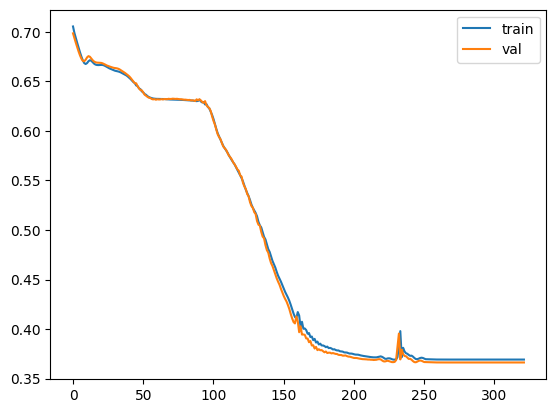

In [21]:
from EarlyStopping import EarlyStopping
import matplotlib.pyplot as plt

def get_pred(data, model):
    return model(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        edge_label_index=data.edge_label_index
    )

@torch.no_grad()
def get_pred_no_grad(data, model):
    return model(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        edge_label_index=data.edge_label_index
    )

@torch.no_grad()
def get_loss_in_eval(data, model):
    model.eval()
    pred = get_pred_no_grad(data, model)
    target = data.edge_label.reshape(-1, 1)
    loss = torch.nn.functional.binary_cross_entropy(pred, target)
    return loss

def get_loss(data, model):
    pred = get_pred(data, model)
    target = data.edge_label.reshape(-1, 1)
    loss = torch.nn.functional.binary_cross_entropy(pred, target)
    return loss

model = GNN((4, 6), 12)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
early_stopping = EarlyStopping(patience=30, verbose=False)

trainLoss_list = []
valLoss_list = []

for epoch in range(0, 1000):
    model.train()
    optimizer.zero_grad()

    train_loss = get_loss(train_data, model)
    train_loss.backward()

    optimizer.step()
    scheduler.step(train_loss)

    val_loss = get_loss_in_eval(val_data, model)

    trainLoss_list.append(train_loss.detach().numpy())
    valLoss_list.append(val_loss.detach().numpy())

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, val_Loss: {val_loss:.4f}')

plt.plot(trainLoss_list, label='train')
plt.plot(valLoss_list, label='val')
plt.legend()
plt.show()

In [22]:
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
test_pred = get_pred_no_grad(test_data, model)
test_label = test_data.edge_label.reshape(-1, 1)
test_loss = get_loss_in_eval(test_data, model)
test_loss

C:\Users\user\AppData\Local\Temp\ipykernel_23620\1533526080.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pt"))


tensor(0.3616)